<a href="https://colab.research.google.com/github/SeptiLutfiana/MESIN-LEARNING/blob/main/Pertemuan10_Praktikum1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

RNN untuk Analisis Sentimen

In [2]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [3]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [4]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [5]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label) ini:

In [6]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b'Don\'t even ask me why I watched this! The only excuse I can come up with that I was sick with Bronchitis and too weak to change the channel. :) It\'s too terrible for words, the movie that is, not the Bronchitis. The acting is deplorable, Richard Grieco hams it up as a trigger-happy, gun-slinging serial killer with a penchant for knocking off cops. Nick Mancuso phones in a performance as the cop on his trail and Nancy Allen manages to put in the only sympathetic role in the entire film. The script is dismal, peppered with clich\xc3\xa9d lines, "Are you ready, Pardner?" purrs Richard Grieco to every single one of his victims. Dire. Avoid.'
 b"Sniffing girl's panties kills a guy...and a stupid freaky puppet says a lot of stupid freaky things......My eyes could not leave the screen, my finger could not leave the Fast Forward button....I had to rewatch this spectacle to see if I had really experienced what I thought...I did.....God help us all!"
 b'Fashionably fragmented, yet i

**Buat Teks Encoder**

Teks mentah yang dimuat oleh tfds perlu diproses sebelum dapat digunakan dalam model. Cara termudah memproses teks untuk pelatihan adalah menggunakan lapisan TextVectorization. Lapisan ini memiliki banyak kemampuan, namun pada tutorial ini menggunakan perilaku default. Buat lapisan tersebut, dan teruskan teks kumpulan data ke metode .adapt lapisan:

In [7]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

Metode .adapt mengatur kosakata lapisan. 20 token pertama dapat dilihat dengan kode berikut. Setelah padding dan token yang tidak diketahui, mereka diurutkan berdasarkan frekuensi:

In [8]:
vocab=np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Setelah kosakata diatur, lapisan dapat mengkodekan teks ke dalam indeks. Tensor indeks diberi bantalan 0 ke urutan terpanjang dalam batch (kecuali jika Anda menetapkan output_sequence_length tetap):

In [9]:
encoded_example=encoder(example)[:3].numpy()
encoded_example

array([[ 90,  54, 915, ...,   0,   0,   0],
       [  1, 476,   1, ...,   0,   0,   0],
       [  1,   1, 241, ...,   0,   0,   0]])

In [10]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Don\'t even ask me why I watched this! The only excuse I can come up with that I was sick with Bronchitis and too weak to change the channel. :) It\'s too terrible for words, the movie that is, not the Bronchitis. The acting is deplorable, Richard Grieco hams it up as a trigger-happy, gun-slinging serial killer with a penchant for knocking off cops. Nick Mancuso phones in a performance as the cop on his trail and Nancy Allen manages to put in the only sympathetic role in the entire film. The script is dismal, peppered with clich\xc3\xa9d lines, "Are you ready, Pardner?" purrs Richard Grieco to every single one of his victims. Dire. Avoid.'
Round-trip:  dont even ask me why i watched this the only [UNK] i can come up with that i was [UNK] with [UNK] and too weak to change the [UNK] its too terrible for words the movie that is not the [UNK] the acting is [UNK] richard [UNK] [UNK] it up as a [UNK] [UNK] [UNK] killer with a [UNK] for [UNK] off [UNK] [UNK] [UNK] [UNK] in a perf

**Buat Model**

In [11]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [12]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [13]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 7s 7s/step
[0.00330771]


In [14]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 0s 27ms/step
[0.00330771]


In [15]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 61ms/step
[0.00330771]


In [16]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

**Train Model**

In [17]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 50s 103ms/step - loss: 0.6284 - accuracy: 0.5858 - val_loss: 0.4945 - val_accuracy: 0.7854
Epoch 2/10
391/391 [==============================] - 27s 68ms/step - loss: 0.4163 - accuracy: 0.7998 - val_loss: 0.3726 - val_accuracy: 0.8292
Epoch 3/10
391/391 [==============================] - 26s 67ms/step - loss: 0.3504 - accuracy: 0.8431 - val_loss: 0.3440 - val_accuracy: 0.8453
Epoch 4/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3235 - accuracy: 0.8584 - val_loss: 0.3330 - val_accuracy: 0.8484
Epoch 5/10
391/391 [==============================] - 24s 62ms/step - loss: 0.3113 - accuracy: 0.8654 - val_loss: 0.3298 - val_accuracy: 0.8490
Epoch 6/10
391/391 [==============================] - 24s 61ms/step - loss: 0.3074 - accuracy: 0.8677 - val_loss: 0.3256 - val_accuracy: 0.8536
Epoch 7/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3057 - accuracy: 0.8694 - val_loss: 0.3229 - val_accuracy

In [18]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 12s 30ms/step - loss: 0.3177 - accuracy: 0.8614
Test Loss: 0.3177017271518707
Test Accuracy: 0.8613600134849548


(0.0, 0.644946938753128)

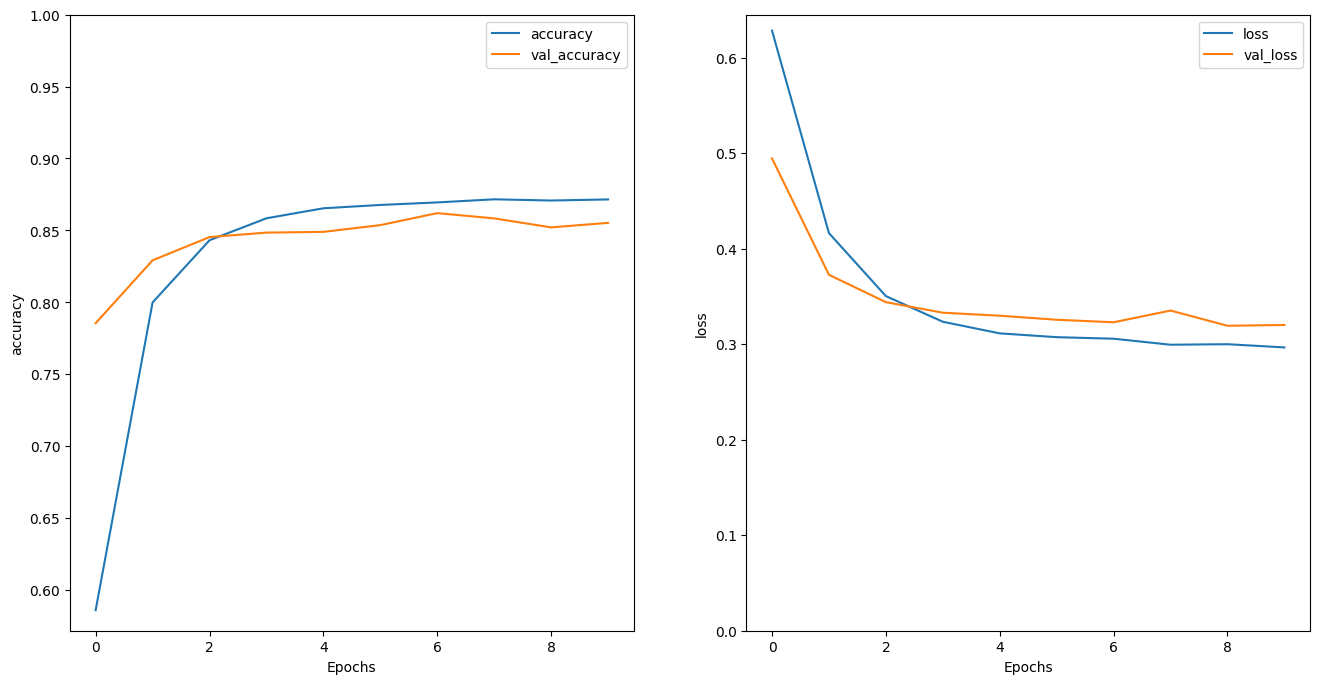

In [19]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [20]:
sample_text = ('The movie was cool. The animation and the graphics '
'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 3s 3s/step


Hal yang menarik dari penggunaan RNN dengan return_sequences=True adalah outputnya masih memiliki 3 axis, sama seperti inputnya, sehingga bisa diteruskan ke layer RNN lain, seperti ini:

In [21]:
model = tf.keras.Sequential([
encoder,
tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
tf.keras.layers.Dense(64, activation='relu'),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(1)
])

In [22]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
optimizer=tf.keras.optimizers.Adam(1e-4),
metrics=['accuracy'])

In [23]:
history = model.fit(train_dataset, epochs=10,
validation_data=test_dataset,
validation_steps=30)

Epoch 1/10
391/391 [==============================] - 78s 153ms/step - loss: 0.6237 - accuracy: 0.5834 - val_loss: 0.4209 - val_accuracy: 0.8068
Epoch 2/10
391/391 [==============================] - 47s 120ms/step - loss: 0.3815 - accuracy: 0.8344 - val_loss: 0.3484 - val_accuracy: 0.8573
Epoch 3/10
391/391 [==============================] - 46s 117ms/step - loss: 0.3347 - accuracy: 0.8591 - val_loss: 0.3482 - val_accuracy: 0.8464
Epoch 4/10
391/391 [==============================] - 45s 114ms/step - loss: 0.3208 - accuracy: 0.8633 - val_loss: 0.3250 - val_accuracy: 0.8557
Epoch 5/10
391/391 [==============================] - 45s 115ms/step - loss: 0.3138 - accuracy: 0.8662 - val_loss: 0.3265 - val_accuracy: 0.8609
Epoch 6/10
391/391 [==============================] - 46s 116ms/step - loss: 0.3072 - accuracy: 0.8692 - val_loss: 0.3162 - val_accuracy: 0.8573
Epoch 7/10
391/391 [==============================] - 46s 118ms/step - loss: 0.3043 - accuracy: 0.8702 - val_loss: 0.3203 - val_ac

In [24]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 19s 48ms/step - loss: 0.3156 - accuracy: 0.8618
Test Loss: 0.31562885642051697
Test Accuracy: 0.8618000149726868


In [25]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics ' 'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 5s 5s/step
[[-1.8496227]]


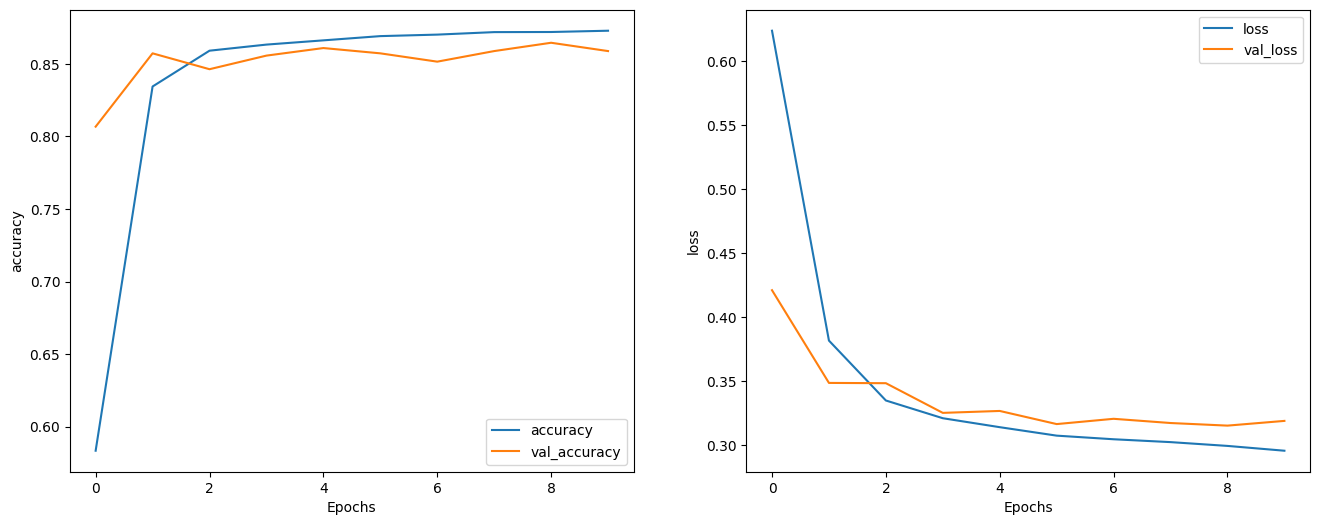

In [26]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')